# **Import Libraries**

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string

import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizer
from transformers import TFMBartModel,AutoTokenizer


import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


seed=42
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-2-8c45691b2b01>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.expand_frame_repr', False)  # Display DataFrame in a single frame

# EDA

In [ ]:
class Datapreprocessing:


    def __init__(self,file_path,max_length):
        self.max_length = max_length
        self.file_path = file_path



    def dataframe(self):
        with open(self.file_path,encoding='utf-8') as f:
            text_li = f.readlines()
        en_text = []
        zh_text = []
        en_sentence_center = []
        zh_sentence_center = []
        en_align_text = []
        zh_align_text = []
        label_text = []
        en_align_index = []
        zh_align_index = []
        pair_list1 = []
        pair_list2 = []

        for i, line in enumerate(text_li):
            if i%4== 0:
                en_text.append(line.strip())
            elif i%4 ==1:
                zh_text.append(line.strip())
            elif i%4==2:
                en_align = line.strip().split(':')[0]
                zh_align = line.strip().split(':')[-1]
                en_align_text.append(en_align)
                zh_align_text.append(zh_align)
            elif i%4==3:
                label_text.append(line.strip())
        for en, zh, en_sent,zh_sent in zip(en_align_text, zh_align_text, en_text, zh_text):
            pair1 = en + '[SEP]' + zh + '[SEP]' + en_sent+ '[SEP]' + zh_sent
            pair_list1.append(pair1)
        for en, en_sent in zip(en_align_text, en_text):
            pair2 = en + '[SEP]' + en_sent
            pair_list2.append(pair2)








        data = {
        'en_sent': en_text,
        'zh_sent': zh_text,
        'en_align': en_align_text,
        'zh_align': zh_align_text,
        'pair1':pair_list1,
        'pair2':pair_list2,
        'label': label_text}

        df = pd.DataFrame(data)

        return df



    def test1_df(self):
        with open(self.file_path,encoding='latin-1') as q:
            text_li = q.readlines()
        text_list = []
        label_list = []

        for all in text_li:
            text = all.split('@')[0]
            label = all.split('@')[1].strip()
            text_list.append(text)
            label_list.append(label)
        data = {
            'sent': text_list,
            'label':label_list
        }
        df = pd.DataFrame(data)
        return df



file_path = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/debug_data/train.txt'
file_path_test = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/debug_data/test.txt'

max_len = 512
df = Datapreprocessing(file_path, max_len)
df_train = df.dataframe()
print(df_train.head(5))

df_test = Datapreprocessing(file_path_test, max_len)
df_test = df_test.dataframe()
print(df_test.head(5))

                                             en_sent                                            zh_sent     en_align zh_align                                              pair1                                              pair2                label
0       Tamara, tell him it has to be a real wedding                              Tamara，跟他说 必须有正式的结婚仪式           it           it[SEP][SEP]Tamara, tell him it has to be a re...  it[SEP]Tamara, tell him it has to be a real we...  unaligned_reduction
1  But researchers and development workers say th...  但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...  researchers      科学家  researchers[SEP]科学家[SEP]But researchers and de...  researchers[SEP]But researchers and developmen...       generalization
2  Ascorbic acid also stimulates your body's prod...               抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。         your           your[SEP][SEP]Ascorbic acid also stimulates yo...  your[SEP]Ascorbic acid also stimulates your bo...  unaligned_reduction
3  B

In [ ]:
df_train.head()


,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"Tamara, tell him it has to be a real wedding",Tamara，跟他说 必须有正式的结婚仪式,it,,"it[SEP][SEP]Tamara, tell him it has to be a re...","it[SEP]Tamara, tell him it has to be a real we...",unaligned_reduction
1,But researchers and development workers say th...,但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...,researchers,科学家,researchers[SEP]科学家[SEP]But researchers and de...,researchers[SEP]But researchers and developmen...,generalization
2,Ascorbic acid also stimulates your body's prod...,抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。,your,,your[SEP][SEP]Ascorbic acid also stimulates yo...,your[SEP]Ascorbic acid also stimulates your bo...,unaligned_reduction
3,But I have never actively thought of it as suc...,"但我从来没有像这样的积极思想,我爱我的养父母。",parents,父母,parents[SEP]父母[SEP]But I have never actively t...,parents[SEP]But I have never actively thought ...,lexical_shift
4,STUDY ON HEAT TRANSFER ENHANCEMENT OF FREON-12...,整体型内螺旋翅片管氟利昂12干式蒸发器传热强化试验研究,OF,,OF[SEP][SEP]STUDY ON HEAT TRANSFER ENHANCEMENT...,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,unaligned_reduction


In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I leave it as an exercise for you to include a...,我将其他一些检查留给您作为练习，其中包括查看是否错误地（或故意地）将TableName和Fi...,mistake,错误,mistake[SEP]错误[SEP]I leave it as an exercise f...,mistake[SEP]I leave it as an exercise for you ...,transposition
1,Baume hydrometers are ordinarily used to deter...,波美计一般用于制酸厂、染织厂、饴糖厂、盐场等部门对各种液体进行测定。,mill,厂,mill[SEP]厂[SEP]Baume hydrometers are ordinaril...,mill[SEP]Baume hydrometers are ordinarily used...,modulation_transposition
2,"The venture involved intrigue, lies, nemesis —...",这场冒险包含了阴谋诡计，谎言，不可避免的结果—以及没有结束的一个教训。,intrigue,阴谋诡计,intrigue[SEP]阴谋诡计[SEP]The venture involved int...,"intrigue[SEP]The venture involved intrigue, li...",equivalence
3,"The twist with Icera’s chips, says Steve Allpr...",据其中一位创始人，斯蒂夫·奥佩斯（Steve Allpress），介绍，Icera芯片的发展...,twist,发展,"twist[SEP]发展[SEP]The twist with Icera’s chips,...","twist[SEP]The twist with Icera’s chips, says S...",generalization
4,Article A sole proprietorship enterprise shall...,第六条个人独资企业应当依法招用职工。职工的合法权益受法律保护。,are protected,保护,are protected[SEP]保护[SEP]Article A sole propri...,are protected[SEP]Article A sole proprietorshi...,modulation


In [ ]:
print('Train shape:',df_train.shape)
print('Test shape:',df_test.shape)

Train shape: (77587, 7)
Test shape: (8621, 7)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77587 entries, 0 to 77586
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   en_sent   77587 non-null  object
 1   zh_sent   77587 non-null  object
 2   en_align  77587 non-null  object
 3   zh_align  77587 non-null  object
 4   pair1     77587 non-null  object
 5   pair2     77587 non-null  object
 6   label     77587 non-null  object
dtypes: object(7)
memory usage: 4.1+ MB


In [ ]:
label_counts = df_train.label.value_counts()
total_samples = len(df_train)
label_percentages = label_counts / total_samples
print(label_percentages)

literal                     0.144754
transposition               0.115999
unaligned_explicitation     0.115303
unaligned_reduction         0.109554
lexical_shift               0.107093
equivalence                 0.102002
generalization              0.097619
modulation                  0.092503
particularization           0.069612
modulation_transposition    0.045562
Name: label, dtype: float64


In [ ]:
label_counts = df_test.label.value_counts()
total_samples = len(df_test)
label_percentages = label_counts / total_samples
print(label_percentages)

literal                     0.144763
transposition               0.115996
unaligned_explicitation     0.115300
unaligned_reduction         0.109616
lexical_shift               0.107064
equivalence                 0.101960
generalization              0.097668
modulation                  0.092449
particularization           0.069597
modulation_transposition    0.045586
Name: label, dtype: float64


In [ ]:
def sentiment_categories(category):
    if category=='literal':
        return 0
    elif category=='transposition':
        return 1
    elif category=='unaligned_explicitation':
        return 2
    elif category=='unaligned_reduction':
        return 3
    elif category=='lexical_shift':
        return 4
    elif category=='equivalence':
        return 5
    elif category=='generalization':
        return 6
    elif category=='modulation':
        return 7
    elif category=='particularization':
        return 8
    elif category=='modulation_transposition':
        return 9

In [ ]:
df_train['label']=df_train['label'].apply(sentiment_categories)


In [ ]:
df_train.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"Tamara, tell him it has to be a real wedding",Tamara，跟他说 必须有正式的结婚仪式,it,,"it[SEP][SEP]Tamara, tell him it has to be a re...","it[SEP]Tamara, tell him it has to be a real we...",3
1,But researchers and development workers say th...,但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...,researchers,科学家,researchers[SEP]科学家[SEP]But researchers and de...,researchers[SEP]But researchers and developmen...,6
2,Ascorbic acid also stimulates your body's prod...,抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。,your,,your[SEP][SEP]Ascorbic acid also stimulates yo...,your[SEP]Ascorbic acid also stimulates your bo...,3
3,But I have never actively thought of it as suc...,"但我从来没有像这样的积极思想,我爱我的养父母。",parents,父母,parents[SEP]父母[SEP]But I have never actively t...,parents[SEP]But I have never actively thought ...,4
4,STUDY ON HEAT TRANSFER ENHANCEMENT OF FREON-12...,整体型内螺旋翅片管氟利昂12干式蒸发器传热强化试验研究,OF,,OF[SEP][SEP]STUDY ON HEAT TRANSFER ENHANCEMENT...,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,3


In [ ]:
df_test['label']=df_test['label'].apply(sentiment_categories)

In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I leave it as an exercise for you to include a...,我将其他一些检查留给您作为练习，其中包括查看是否错误地（或故意地）将TableName和Fi...,mistake,错误,mistake[SEP]错误[SEP]I leave it as an exercise f...,mistake[SEP]I leave it as an exercise for you ...,1
1,Baume hydrometers are ordinarily used to deter...,波美计一般用于制酸厂、染织厂、饴糖厂、盐场等部门对各种液体进行测定。,mill,厂,mill[SEP]厂[SEP]Baume hydrometers are ordinaril...,mill[SEP]Baume hydrometers are ordinarily used...,9
2,"The venture involved intrigue, lies, nemesis —...",这场冒险包含了阴谋诡计，谎言，不可避免的结果—以及没有结束的一个教训。,intrigue,阴谋诡计,intrigue[SEP]阴谋诡计[SEP]The venture involved int...,"intrigue[SEP]The venture involved intrigue, li...",5
3,"The twist with Icera’s chips, says Steve Allpr...",据其中一位创始人，斯蒂夫·奥佩斯（Steve Allpress），介绍，Icera芯片的发展...,twist,发展,"twist[SEP]发展[SEP]The twist with Icera’s chips,...","twist[SEP]The twist with Icera’s chips, says S...",6
4,Article A sole proprietorship enterprise shall...,第六条个人独资企业应当依法招用职工。职工的合法权益受法律保护。,are protected,保护,are protected[SEP]保护[SEP]Article A sole propri...,are protected[SEP]Article A sole proprietorshi...,7


In [ ]:
tokenizer=AutoTokenizer.from_pretrained("facebook/mbart-large-cc25")

In [ ]:
tweet_len=[]
for text in df_test.pair1:
    tokens=tokenizer.encode(text,max_length=512)
    tweet_len.append(len(tokens))
print(max(tweet_len))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


512


<ipython-input-19-aa8050e070b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_len)


Text(0.5, 0, 'Number of words')

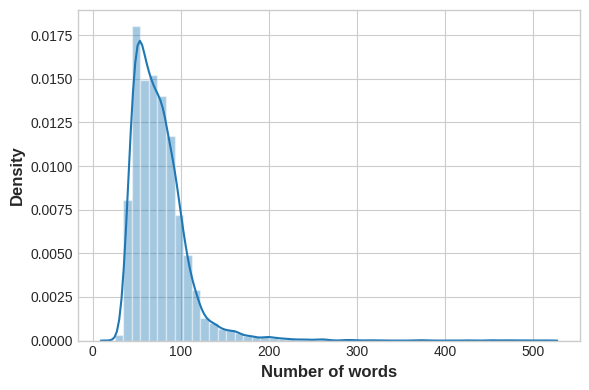

In [ ]:
f,ax=plt.subplots(figsize=(6,4))
sns.distplot(tweet_len)
plt.xlabel('Number of words')

In [ ]:
df_train=df_train[['pair1','pair2','label']]


In [ ]:
df_train.head()

,pair1,pair2,label
0,"it[SEP][SEP]Tamara, tell him it has to be a re...","it[SEP]Tamara, tell him it has to be a real we...",3
1,researchers[SEP]科学家[SEP]But researchers and de...,researchers[SEP]But researchers and developmen...,6
2,your[SEP][SEP]Ascorbic acid also stimulates yo...,your[SEP]Ascorbic acid also stimulates your bo...,3
3,parents[SEP]父母[SEP]But I have never actively t...,parents[SEP]But I have never actively thought ...,4
4,OF[SEP][SEP]STUDY ON HEAT TRANSFER ENHANCEMENT...,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,3


In [ ]:
df_test=df_test[['pair1','pair2','label']]

In [ ]:
df_test.head()

,pair1,pair2,label
0,mistake[SEP]错误[SEP]I leave it as an exercise f...,mistake[SEP]I leave it as an exercise for you ...,1
1,mill[SEP]厂[SEP]Baume hydrometers are ordinaril...,mill[SEP]Baume hydrometers are ordinarily used...,9
2,intrigue[SEP]阴谋诡计[SEP]The venture involved int...,"intrigue[SEP]The venture involved intrigue, li...",5
3,"twist[SEP]发展[SEP]The twist with Icera’s chips,...","twist[SEP]The twist with Icera’s chips, says S...",6
4,are protected[SEP]保护[SEP]Article A sole propri...,are protected[SEP]Article A sole proprietorshi...,7


# Cleaning the Tweets

In [ ]:
#shuffle train data and reset index
df_train=df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,pair1,pair2,label
0,crier[SEP]跳[SEP]The slogan crier saw the dog a...,crier[SEP]The slogan crier saw the dog and fro...,9
1,"nature[SEP]自然[SEP]In what sense, we could ask ...","nature[SEP]In what sense, we could ask ourselv...",1
2,[SEP]（Laura Bilodeau Overdeck）曾是新泽西州萨米特市（Summi...,[SEP]The site posts a playful math question ea...,2
3,are opened[SEP]被回收[SEP]“After the letters are ...,are opened[SEP]“After the letters are opened a...,0
4,"be[SEP][SEP]All friends of Africa, that will h...","be[SEP]All friends of Africa, that will have r...",3


In [ ]:
df_test=df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,pair1,pair2,label
0,"kilometers[SEP]公里[SEP]Chery's factory, located...","kilometers[SEP]Chery's factory, located in Anh...",5
1,"it[SEP][SEP]For example, a cancer drug might b...","it[SEP]For example, a cancer drug might be app...",3
2,nights[SEP]次日[SEP]The inspector then asked the...,nights[SEP]The inspector then asked the old la...,9
3,manner[SEP]举止[SEP]We didn't trust him at first...,"manner[SEP]We didn't trust him at first, but h...",9
4,is located[SEP]位于[SEP]The city is located in t...,is located[SEP]The city is located in the nort...,7


# Splitting the data into train/valid/test

In [ ]:
X1=df_train['pair1'].values
X2=df_train['pair2'].values
y=df_train['label'].values

In [ ]:
# X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1,X2,y,test_size=0.1,stratify=y,random_state=42)
X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1,X2,y,test_size=0.1,stratify=y,random_state=42)

In [ ]:
X1_test=df_test['pair1'].values
X2_test=df_test['pair2'].values
y_test=df_test['label'].values

In [ ]:
y_train_label=y_train.copy()
y_val_label=y_val.copy()
y_test_label=y_test.copy()

In [ ]:
hotencoder=preprocessing.OneHotEncoder()
y_train=hotencoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val=hotencoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test=hotencoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Model2: BERT Model

In [ ]:
MAX_LEN=512

In [ ]:
def tokenize(tweets,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(tweets)):
        encoding=tokenizer.encode_plus(tweets[i],truncation=True,add_special_tokens=True,max_length=MAX_LEN,
                                       padding='max_length',return_attention_mask=True)
        if len(encoding['input_ids']) != 512:
            print(len(encoding['input_ids']))
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)


In [ ]:
train1_input_ids,train1_attention_masks=tokenize(X1_train,MAX_LEN)
test1_input_ids,test1_attention_masks=tokenize(X1_test,MAX_LEN)
val1_input_ids,val1_attention_masks=tokenize(X1_val,MAX_LEN)

train2_input_ids,train2_attention_masks=tokenize(X2_train,MAX_LEN)
test2_input_ids,test2_attention_masks=tokenize(X2_test,MAX_LEN)
val2_input_ids,val2_attention_masks=tokenize(X2_val,MAX_LEN)

In [ ]:
bert_model = TFMBartModel.from_pretrained("facebook/mbart-large-cc25")

Some layers from the model checkpoint at facebook/mbart-large-cc25 were not used when initializing TFMBartModel: ['final_logits_bias']
- This IS expected if you are initializing TFMBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFMBartModel were initialized from the model checkpoint at facebook/mbart-large-cc25.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMBartModel for predictions without further training.


In [ ]:
for layer in bert_model.model.decoder.layers:
    layer.trainable = False
for layer in bert_model.model.decoder.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    # Task 1 inputs
    input_ids_task1 = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks_task1 = tf.keras.Input(shape=(max_len,), dtype='int32')
    embeddings_task1 = bert_model([input_ids_task1, attention_masks_task1])[0][:, 0, :]
    output_task1 = tf.keras.layers.Dense(10, activation='softmax', name='task1_output')(embeddings_task1)

    # Task 2 inputs
    input_ids_task2 = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks_task2 = tf.keras.Input(shape=(max_len,), dtype='int32')
    embeddings_task2 = bert_model([input_ids_task2, attention_masks_task2])[0][:, 0, :]
    output_task2 = tf.keras.layers.Dense(10, activation='softmax', name='task2_output')(embeddings_task2)

    # Task 1 model
    model_task1 = tf.keras.models.Model(inputs=[input_ids_task1, attention_masks_task1], outputs=output_task1)
    loss_fn_task1 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy_task1 = tf.keras.metrics.CategoricalAccuracy(name='accuracy_task1')

    # Task 2 model
    model_task2 = tf.keras.models.Model(inputs=[input_ids_task2, attention_masks_task2], outputs=output_task2)
    loss_fn_task2 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy_task2 = tf.keras.metrics.CategoricalAccuracy(name='accuracy_task2')

    # Combine the models and losses
    model = tf.keras.models.Model(inputs=[input_ids_task1, attention_masks_task1, input_ids_task2, attention_masks_task2],
                                  outputs=[output_task1, output_task2])

    alpha = 0.2  # Weighting factor for task1 loss
    beta = 0.8   # Weighting factor for task2 loss

    model.compile(optimizer,
                  loss={'task1_output': loss_fn_task1, 'task2_output': loss_fn_task2},
                  loss_weights={'task1_output': alpha, 'task2_output': beta},
                  metrics={'task1_output': accuracy_task1, 'task2_output': accuracy_task2})

    return model






In [ ]:
model=create_model(bert_model,MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback

checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/3_mbart/save_checkpoints/mbart_tfmbart_best_checkpoint.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,     # Save only the best checkpoint
    mode='max'               # Mode for comparison (e.g., maximize the metric)
)


initial_l2_regularization = 0.1

def dynamic_l2_regularization(epoch):
    if epoch <= 5:
        return 0
    elif epoch == 6:
        return initial_l2_regularization
    elif epoch > 6:
        return initial_l2_regularization * 0.1  # Update the regularization strength after epoch 10



# Custom callback to update L2 regularization strength during training
class L2RegularizationUpdater(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        l2_regularization = dynamic_l2_regularization(epoch)
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                layer.kernel_regularizer = regularizers.l2(l2_regularization)
        print(f"L2 regularization strength: {l2_regularization}")

# Create an instance of the custom callback
l2_callback = L2RegularizationUpdater()

def learning_rate_scheduler(epoch, learning_rate):
    if epoch <= 5:
        return learning_rate  # Keep the initial learning rate for the first 10 epochs
    else:
        return learning_rate * tf.math.exp(-0.1)  # Decrease the learning rate exponentially

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [train1_input_ids, train1_attention_masks, train2_input_ids, train2_attention_masks],
    y_train,
    validation_data=([val1_input_ids, val1_attention_masks, val2_input_ids, val2_attention_masks], [y_val, y_val]),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop, checkpoint, lr_scheduler,l2_callback]  # Pass the early_stop callback
)



L2 regularization strength: 0
Epoch 1/50
 2055/17457 [==>...........................] - ETA: 1:30:08 - loss: 2.7429 - task1_output_loss: 3.2887 - task2_output_loss: 2.6065 - task1_output_accuracy_task1: 0.1867 - task2_output_accuracy_task2: 0.2187

In [ ]:
res=model.predict([test1_input_ids,test1_attention_masks,test2_input_ids,test2_attention_masks])

270/270 [==============================] - 271s 907ms/step


In [ ]:
output_task1 = res[0]  # Predictions for task 1
output_task2 = res[1]  # Predictions for task 2

y_pred_task1 = np.zeros_like(output_task1)
y_pred_task1[np.arange(len(y_pred_task1)), output_task1.argmax(1)] = 1

y_pred_task2 = np.zeros_like(output_task2)
y_pred_task2[np.arange(len(y_pred_task2)), output_task2.argmax(1)] = 1

In [ ]:
confusion_matrix(y_test.argmax(1),y_pred_task2.argmax(1))

array([[948,  87,   0,  51,  15,  10,  28,  64,  21,  24],
       [110, 723,   0,   2,  56,  20,  45,  22,   8,  14],
       [  0,   0, 994,   0,   0,   0,   0,   0,   0,   0],
       [ 21,   1,   0, 905,   0,   0,   0,   1,   1,  16],
       [  8,  37,   0,   0, 781,   5,  18,  65,   3,   6],
       [ 12,   9,   0,   0,   3, 818,  11,  22,   3,   1],
       [ 42,  38,   0,   5,  66,  27, 619,   1,  15,  29],
       [ 28,  30,   0,   1,  50,  53,   3, 627,   5,   0],
       [ 25,  28,   0,  32,  22,   8,  45,   2, 435,   3],
       [ 45,  35,   0,   2,  38,  18,  33,   5,   6, 211]])

In [ ]:
class_labels=['literal','transposition','unaligned_explicitation','unaligned_reduction','lexical_shift','equivalence','generalization','modulation','particularization','modulation_transposition']


In [ ]:
# mbert  en+zh+en_sent+zh_sent
print(classification_report(y_test.argmax(1),y_pred_task2.argmax(1),target_names=class_labels))

                          precision    recall  f1-score   support

                 literal       0.77      0.76      0.76      1248
           transposition       0.73      0.72      0.73      1000
 unaligned_explicitation       1.00      1.00      1.00       994
     unaligned_reduction       0.91      0.96      0.93       945
           lexical_shift       0.76      0.85      0.80       923
             equivalence       0.85      0.93      0.89       879
          generalization       0.77      0.74      0.75       842
              modulation       0.78      0.79      0.78       797
       particularization       0.88      0.72      0.79       600
modulation_transposition       0.69      0.54      0.61       393

                accuracy                           0.82      8621
               macro avg       0.81      0.80      0.80      8621
            weighted avg       0.82      0.82      0.82      8621



<Axes: >

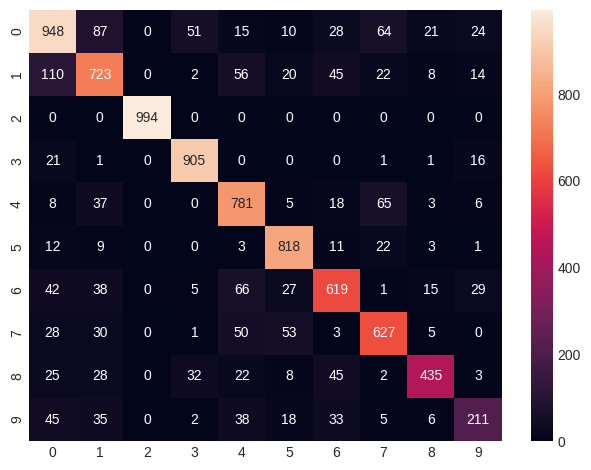

In [ ]:
sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_task2.argmax(1)),annot=True,fmt="d")